In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
day = "0824"
name_notebook = day + "-mh_em_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_8_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/np.max(number_list)
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

# Quantum node

In [8]:
n_aminoacids = len(string_list[0])

In [9]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    # embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    final_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    # measurement = qn.parts.Measurement('Z', (n_aminoacids-1)//2),
    # embedding_n_layers = 3,
    # different_inputs_per_layer = True,
    block_n_layers = 100,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

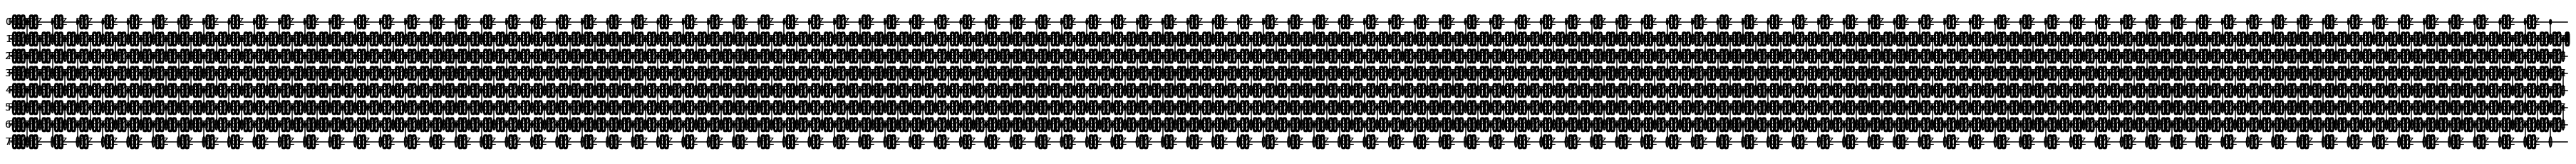

In [10]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [11]:
import torch.nn as nn
import torch
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [12]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer(), ptm.nn.Linear(1,1)]


In [13]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [14]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[0.7020],
        [0.7036]], grad_fn=<AddmmBackward>)
tensor([0.7036], grad_fn=<AddBackward0>)


In [15]:
model.keep_track_params=False

In [16]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.2},
    num_epochs = 100,                
    batch_size = 32,
    # initialization_options = [
    #     {
    #         'type': 'normal_',l
    #         'layer': len(model.model)-1, 
    #         'name': 'bias',
    #         'options': {'mean': 100, 'std': 10},
    #     },{
    #         'type': 'normal_',
    #         'layer': len(model.model)-1,
    #         'name': 'weight',
    #         'options': {'mean': 200, 'std': 10},
    #     },
    # ]
)

Epoch [0/100], Loss: 1.0577, Loss validation: 0.9408


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: 0.3695, 	 target: 0.4501, 	 loss: 0.1790
	 Validation string, 	 i: 1; 	 prediction: 0.3668, 	 target: 0.4239, 	 loss: 0.1347
	 Validation string, 	 i: 2; 	 prediction: 0.3896, 	 target: 0.5335, 	 loss: 0.2697
Epoch [1/100], Loss: 0.5226, Loss validation: 0.4607, Time remaining: ~20.0h 46.0m 57s
	 Validation string, 	 i: 0; 	 prediction: 0.2852, 	 target: 0.4501, 	 loss: 0.3663
	 Validation string, 	 i: 1; 	 prediction: 0.2830, 	 target: 0.4239, 	 loss: 0.3324
	 Validation string, 	 i: 2; 	 prediction: 0.2870, 	 target: 0.5335, 	 loss: 0.4621
Epoch [2/100], Loss: 0.5170, Loss validation: 0.4996, Time remaining: ~19.0h 29.0m 24s
	 Validation string, 	 i: 0; 	 prediction: 0.3582, 	 target: 0.4501, 	 loss: 0.2042
	 Validation string, 	 i: 1; 	 prediction: 0.3609, 	 target: 0.4239, 	 loss: 0.1485
	 Validation string, 	 i: 2; 	 prediction: 0.3529, 	 target: 0.5335, 	 loss: 0.3386
Epoch [3/100], Loss: 0.5198, Loss validation: 0.4567, Time remaining: 

In [17]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0824/txts/0824-mh_em_1qm_model_str_2.txt


Saved in:  peptide-QML/checkpoints/0824/plots/0824-mh_em_1qm_losses_batches_2.png


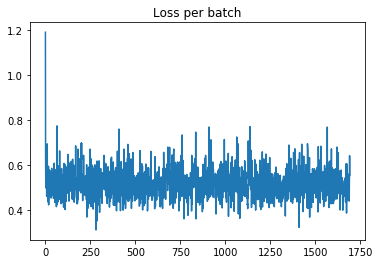

Saved in:  peptide-QML/checkpoints/0824/plots/0824-mh_em_1qm_losses_epoch_2.png


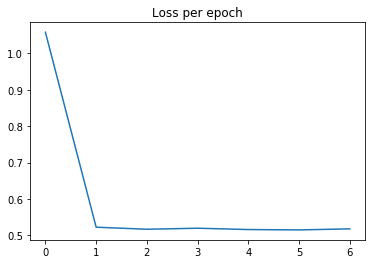

Saved in:  peptide-QML/checkpoints/0824/plots/0824-mh_em_1qm_losses_epoch_validation_2.png


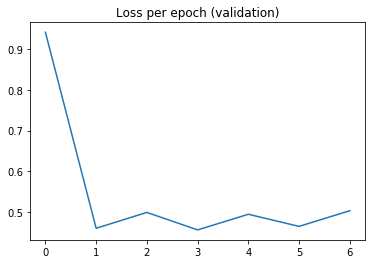

In [18]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

In [19]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.


In [20]:
# model.plot_parameter(layer='7.weights', index=50)

In [21]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as peptide-QML/checkpoints/0824/models/0824-mh_em_1qm_2.pth


Saved in:  peptide-QML/checkpoints/0824/plots/0824-mh_em_1qm_validation_2.png


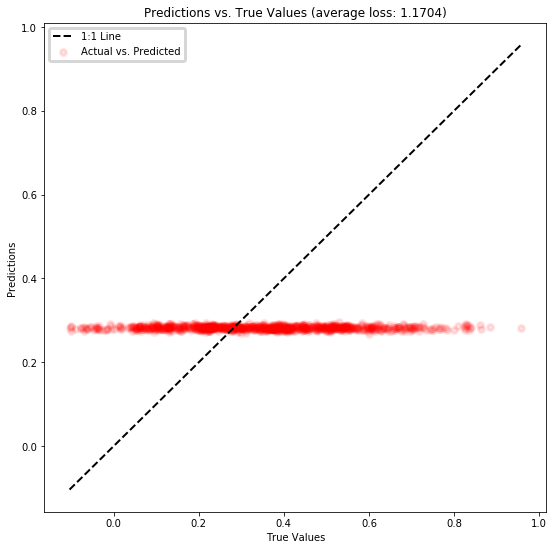

In [22]:
model.plot_validation(save=True, fig_size=(9,9), percentatge=1)

In [23]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: 0.4501, 	 prediction: 0.2785, 	 loss: 0.3813
i: 1, 		 target: 0.5260, 	 prediction: 0.2811, 	 loss: 0.4656
i: 2, 		 target: 0.5872, 	 prediction: 0.2781, 	 loss: 0.5264
i: 3, 		 target: 0.1919, 	 prediction: 0.2789, 	 loss: 0.4536
i: 4, 		 target: 0.5416, 	 prediction: 0.2812, 	 loss: 0.4808
i: 5, 		 target: 0.2330, 	 prediction: 0.2818, 	 loss: 0.2094
i: 6, 		 target: 0.4904, 	 prediction: 0.2823, 	 loss: 0.4244
i: 7, 		 target: 0.3830, 	 prediction: 0.2864, 	 loss: 0.2522
i: 8, 		 target: 0.7012, 	 prediction: 0.2787, 	 loss: 0.6025
i: 9, 		 target: 0.3608, 	 prediction: 0.2819, 	 loss: 0.2186
i: 10, 		 target: 0.4239, 	 prediction: 0.2862, 	 loss: 0.3249
i: 11, 		 target: 0.3036, 	 prediction: 0.2828, 	 loss: 0.0685
i: 12, 		 target: 0.0595, 	 prediction: 0.2842, 	 loss: 3.7780
i: 13, 		 target: 0.4831, 	 prediction: 0.2833, 	 loss: 0.4137
i: 14, 		 target: -0.0618, 	 prediction: 0.2784, 	 loss: 5.5050
i: 15, 		 target: 0.5741, 	 prediction: 0.2843, 	 loss: 0.5047
i

In [24]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main 547e49fd] data trained model
 14 files changed, 1044 insertions(+)
 create mode 100644 checkpoints/0824/models/.gitkeep
 create mode 100644 checkpoints/0824/models/0824-mh_em_1qm_2.pth
 create mode 100644 checkpoints/0824/notebooks/.gitkeep
 create mode 100644 checkpoints/0824/pdfs/.gitkeep
 create mode 100644 checkpoints/0824/plots/.gitkeep
 create mode 100644 checkpoints/0824/plots/0824-mh_em_1qm_losses_batches_2.png
 create mode 100644 checkpoints/0824/plots/0824-mh_em_1qm_losses_epoch_2.png
 create mode 100644 checkpoints/0824/plots/0824-mh_em_1qm_losses_epoch_validation_2.png
 create mode 100644 checkpoints/0824/plots/0824-mh_em_1qm_validation_2.png
 create mode 100644 checkpoints/0824/txts/.gitkeep
 create mode 100644 checkpoints/0824/txts/0824-mh_em_1qm_model_str_2.txt
 create mode 100644 checkpoints/0824/txts/0824-mh_em_1qm_validation_2.txt
 create mode 100644 checkpoints/0824/versions/.gitkeep
 create mode 100644 checkpoints/0824/versions/0824-mh_em_1qm.version
Enumerati